<a href="https://colab.research.google.com/github/Sahab00/Sales-Forecasting-Description/blob/main/code_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
uploaded = files.upload()


Saving dataset.zip to dataset.zip


In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
import matplotlib.pyplot as plt


**Load DATASET**

In [7]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
features = pd.read_csv("features.csv")
stores = pd.read_csv("stores.csv")


**Merge Datasets**

In [8]:
# Merge train
train_merged = pd.merge(train, features, on=["Store","Date","IsHoliday"], how="left")
train_merged = pd.merge(train_merged, stores, on="Store", how="left")

# Merge test
test_merged = pd.merge(test, features, on=["Store","Date","IsHoliday"], how="left")
test_merged = pd.merge(test_merged, stores, on="Store", how="left")

print("Train shape:", train_merged.shape)
print("Test shape:", test_merged.shape)

Train shape: (421570, 16)
Test shape: (115064, 15)


**Handle Missing Values**

In [9]:
train_merged = train_merged.ffill()
test_merged = test_merged.ffill()

**Feature Engineering**

In [10]:
# Convert Date to datetime
train_merged["Date"] = pd.to_datetime(train_merged["Date"])
test_merged["Date"] = pd.to_datetime(test_merged["Date"])

# Extract Year, Month, Week
train_merged["Year"] = train_merged["Date"].dt.year.astype("int32")
train_merged["Month"] = train_merged["Date"].dt.month.astype("int32")
train_merged["Week"] = train_merged["Date"].dt.isocalendar().week.astype("int64")

test_merged["Year"] = test_merged["Date"].dt.year.astype("int32")
test_merged["Month"] = test_merged["Date"].dt.month.astype("int32")
test_merged["Week"] = test_merged["Date"].dt.isocalendar().week.astype("int64")

# Encode IsHoliday (bool → int)
train_merged["IsHoliday"] = train_merged["IsHoliday"].astype(int)
test_merged["IsHoliday"] = test_merged["IsHoliday"].astype(int)

if train_merged["Type"].dtype == "object":
    mapping = {"A": 1, "B": 2, "C": 3}
    train_merged["Type"] = train_merged["Type"].map(mapping)
    test_merged["Type"] = test_merged["Type"].map(mapping)


**Prepare Data for Model**

In [12]:

X = train_merged.drop(["Weekly_Sales", "Date"], axis=1)
y = train_merged["Weekly_Sales"]

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)


**Train XGBoost Model**

In [13]:
model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    tree_method="hist"
)

model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=50
)

[0]	validation_0-rmse:21934.79067
[50]	validation_0-rmse:8090.90624
[100]	validation_0-rmse:6324.72192
[150]	validation_0-rmse:5526.26663
[200]	validation_0-rmse:5170.65938
[250]	validation_0-rmse:4881.51412
[300]	validation_0-rmse:4667.98238
[350]	validation_0-rmse:4492.86638
[400]	validation_0-rmse:4353.44149
[450]	validation_0-rmse:4236.22324
[499]	validation_0-rmse:4139.40012


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=500,
             n_jobs=None, num_parallel_tree=None, ...)

**Evaluate Model**

In [14]:
y_pred = model.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print("Validation RMSE:", rmse)


Validation RMSE: 4139.400132886094


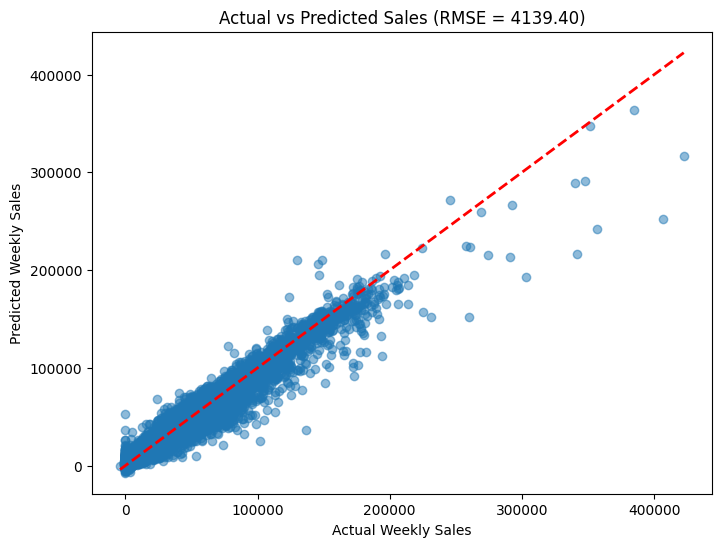

In [18]:
plt.figure(figsize=(8,6))
plt.scatter(y_val, y_pred, alpha=0.5)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)  # Perfect prediction line
plt.xlabel("Actual Weekly Sales")
plt.ylabel("Predicted Weekly Sales")
plt.title(f"Actual vs Predicted Sales (RMSE = {rmse:.2f})")
plt.show()

**Predict on Test Data**

In [19]:
X_test = test_merged.drop(["Date"], axis=1)
test_preds = model.predict(X_test)

**Prediction Distribution (Histogram)**

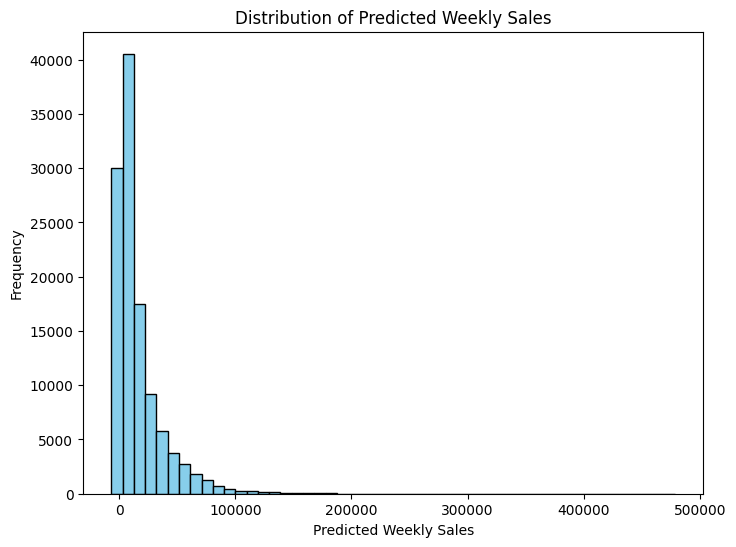

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.hist(test_preds, bins=50, color="skyblue", edgecolor="black")
plt.xlabel("Predicted Weekly Sales")
plt.ylabel("Frequency")
plt.title("Distribution of Predicted Weekly Sales")
plt.show()


**Trend Plot**

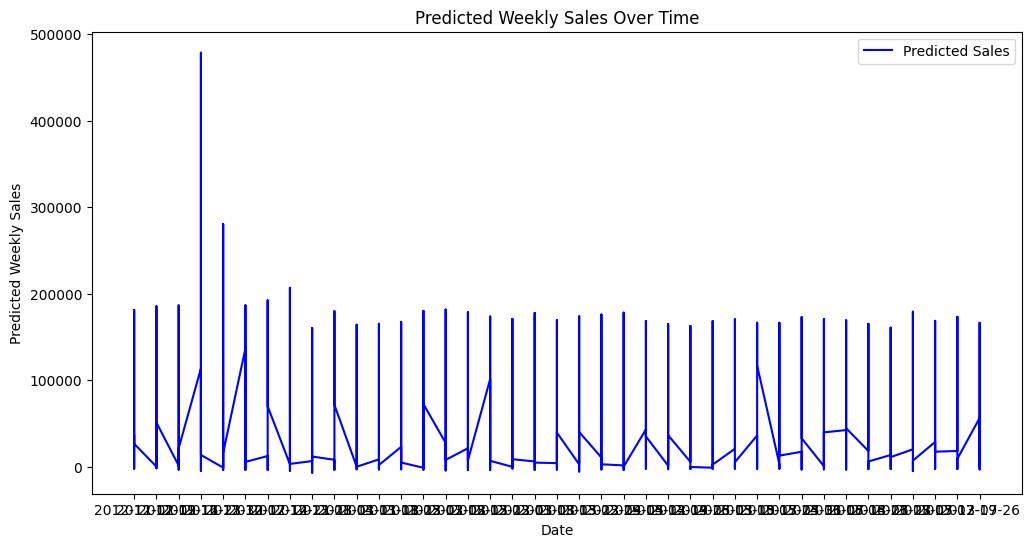

In [21]:
# Test results dataframe
test_results = test[["Store", "Dept", "Date"]].copy()
test_results["Predicted_Weekly_Sales"] = test_preds

# Sort by date
test_results = test_results.sort_values("Date")

plt.figure(figsize=(12,6))
plt.plot(test_results["Date"], test_results["Predicted_Weekly_Sales"], label="Predicted Sales", color="blue")
plt.xlabel("Date")
plt.ylabel("Predicted Weekly Sales")
plt.title("Predicted Weekly Sales Over Time")
plt.legend()
plt.show()


 **Save predictions**

In [22]:
submission = test[["Store", "Dept", "Date"]].copy()
submission["Weekly_Sales"] = test_preds
submission.to_csv("submission.csv", index=False)

print("✅ Submission file saved: submission.csv")


✅ Submission file saved: submission.csv


In [23]:
from sklearn.metrics import mean_absolute_error, r2_score

# Evaluate
y_pred = model.predict(X_val)

rmse = np.sqrt(mean_squared_error(y_val, y_pred))
mae = mean_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print("📊 Model Evaluation Results")
print(f"RMSE: {rmse:.2f}")
print(f"MAE:  {mae:.2f}")
print(f"R²:   {r2:.4f}")



📊 Model Evaluation Results
RMSE: 4139.40
MAE:  2235.01
R²:   0.9671


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


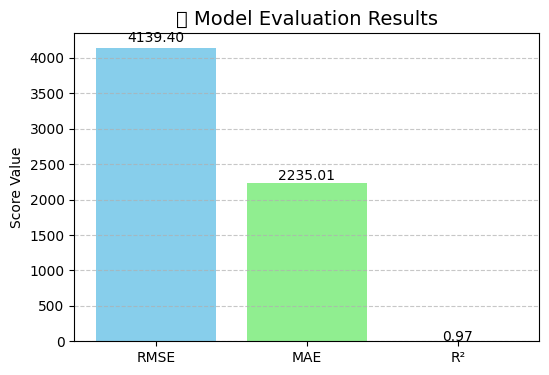

In [24]:
import matplotlib.pyplot as plt

# Metrics values
metrics = {
    "RMSE": 4139.40,
    "MAE": 2235.01,
    "R²": 0.9671
}

# Plot
plt.figure(figsize=(6,4))
plt.bar(metrics.keys(), metrics.values(), color=["skyblue", "lightgreen", "orange"])
plt.title("📊 Model Evaluation Results", fontsize=14)
plt.ylabel("Score Value")
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show values on top of bars
for i, (k,v) in enumerate(metrics.items()):
    plt.text(i, v + (v*0.02), f"{v:.2f}", ha="center", fontsize=10)

plt.show()
